# Semiconductor Bloch Equations - Interactive Experiment

This notebook allows you to experiment with the Semiconductor Bloch Equations and visualize the results interactively.

## Physical System

The Semiconductor Bloch Equations describe the dynamics of electron-hole pairs in semiconductors:

$$\frac{\partial f_n(t)}{\partial t} = -2 \text{Im}[\Omega_n^R(t) p_n^*(t)]$$

$$\frac{\partial p_n(t)}{\partial t} = -\frac{i}{\hbar} [n \Delta\varepsilon - \Delta_0 - E_n] p_n + i [1 - 2 f_n] \Omega_n^R - \frac{p_n}{T_2}$$

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

# Import our modular code
from constants import *
from equations import bloch_equations, g_matrix, laser_pulse, compute_En, compute_Omega_R
from solver import rk4
from visualization import plot_2d_results

# Configure matplotlib for interactive plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ All modules imported successfully!")
print(f"Number of energy levels: {N}")
print(f"Time range: {t_0} to {t_max} fs")
print(f"Default χ₀ values: {chi0_values}")

✓ All modules imported successfully!
Number of energy levels: 100
Time range: -75.0 to 500.0 fs
Default χ₀ values: [0.1, 0.5, 1.0, 1.5, 2.0]


## Experiment 1: Single Simulation

Run a simulation for a specific laser intensity (χ₀) and visualize the results.

In [2]:
# Set parameters for this experiment
chi0_experiment = 1.0  # Change this value to experiment with different laser intensities

print(f"Running simulation for χ₀ = {chi0_experiment}")

# Initial conditions
y0 = np.zeros(3*N)
N_steps = int((t_max - t_0) / dt)

# Solve the equations
args = (chi0_experiment, delta_t, Delta_0, T2, E_R, Delta_epsilon, g_matrix)
t, y = rk4(bloch_equations, t_0, t_max, N_steps, y0, args)

# Extract results
f_n = y[:, :N]
p_n_real = y[:, N:2*N]
p_n_imag = y[:, 2*N:3*N]
p_n = p_n_real + 1j * p_n_imag

# Compute observables
C0 = 2.0
N_t = C0 * np.sum(np.sqrt(np.arange(1, N+1)) * f_n, axis=1)
P_t = np.abs(np.sum(p_n, axis=1))


print(f"✓ Simulation completed!")
print(f"  Max particle density: {np.max(N_t):.4f}")
print(f"  Max polarization: {np.max(P_t):.4f}")

Running simulation for χ₀ = 1.0
✓ Simulation completed!
  Max particle density: 202.1842
  Max polarization: 19.7881


## Visualization: Time Evolution

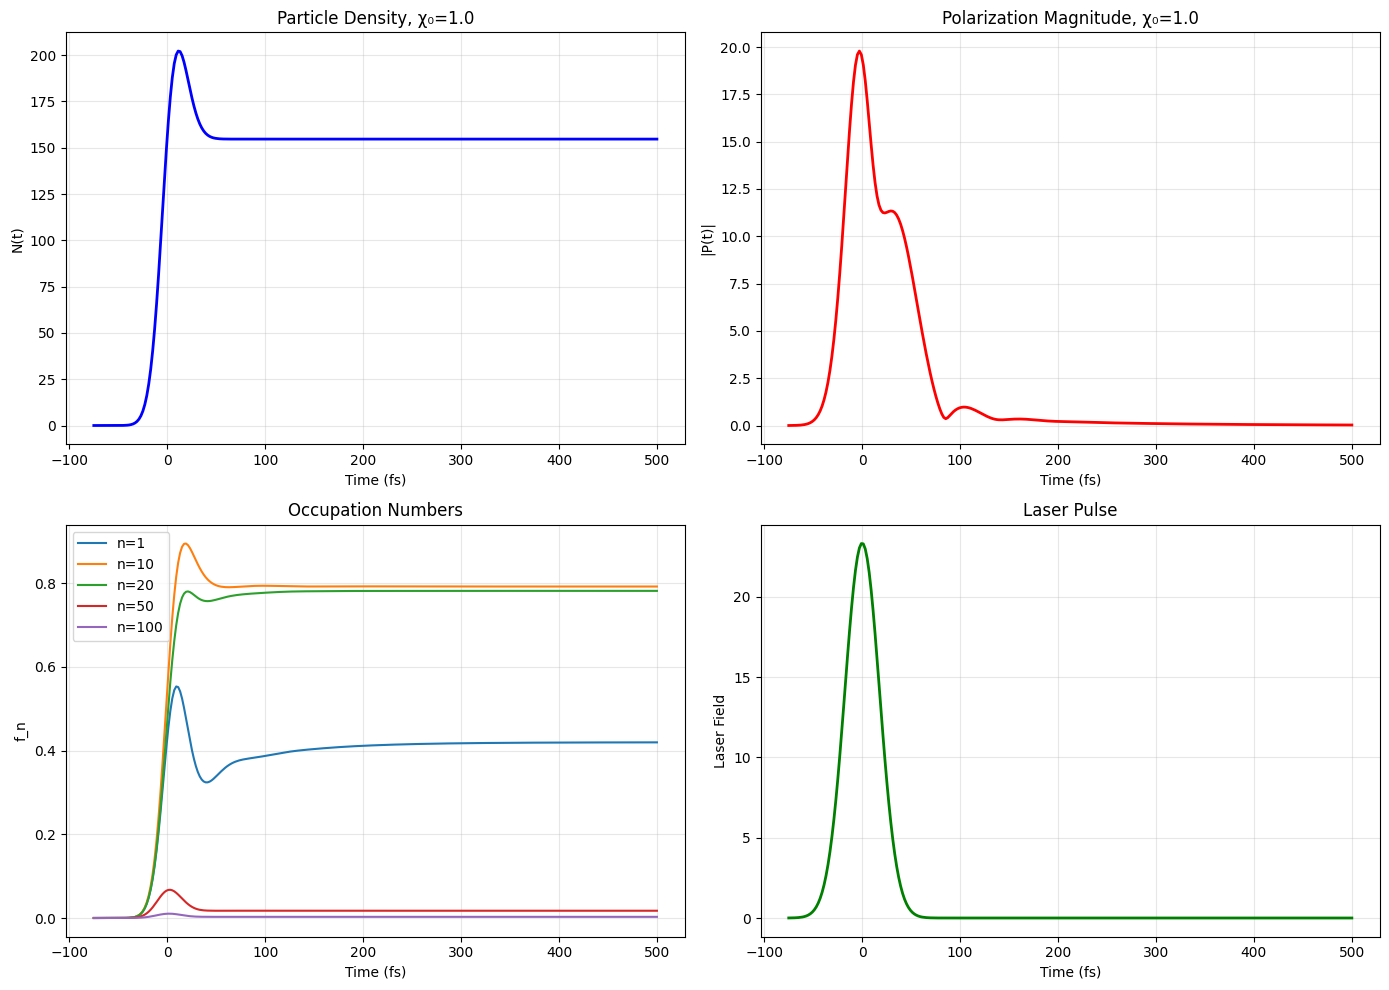

In [3]:
# Plot particle density and polarization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Particle Density
axes[0, 0].plot(t, N_t, linewidth=2, color='blue')
axes[0, 0].set_xlabel('Time (fs)')
axes[0, 0].set_ylabel('N(t)')
axes[0, 0].set_title(f'Particle Density, χ₀={chi0_experiment}')
axes[0, 0].grid(True, alpha=0.3)

# Polarization
axes[0, 1].plot(t, P_t, linewidth=2, color='red')
axes[0, 1].set_xlabel('Time (fs)')
axes[0, 1].set_ylabel('|P(t)|')
axes[0, 1].set_title(f'Polarization Magnitude, χ₀={chi0_experiment}')
axes[0, 1].grid(True, alpha=0.3)

# Occupation numbers for selected levels
selected_levels = [0, 9, 19, 49, 99]
for level in selected_levels:
    if level < N:
        axes[1, 0].plot(t, f_n[:, level], linewidth=1.5, label=f'n={level+1}')
axes[1, 0].set_xlabel('Time (fs)')
axes[1, 0].set_ylabel('f_n')
axes[1, 0].set_title('Occupation Numbers')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Laser pulse
laser = [laser_pulse(ti, chi0_experiment, delta_t) for ti in t]
axes[1, 1].plot(t, laser, linewidth=2, color='green')
axes[1, 1].set_xlabel('Time (fs)')
axes[1, 1].set_ylabel('Laser Field')
axes[1, 1].set_title('Laser Pulse')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment 2: Compare Different Laser Intensities

In [4]:
# Define different chi0 values to compare
chi0_compare = [0.1, 0.5, 1.0, 1.5, 2.0]

results = {}

print("Running simulations for comparison...")
for chi0 in chi0_compare:
    y0 = np.zeros(3*N)
    args = (chi0, delta_t, Delta_0, T2, E_R, Delta_epsilon, g_matrix)
    t, y = rk4(bloch_equations, t_0, t_max, N_steps, y0, args)
    
    f_n = y[:, :N]
    p_n = y[:, N:2*N] + 1j * y[:, 2*N:3*N]
    
    N_t = C0 * np.sum(np.sqrt(np.arange(1, N+1)) * f_n, axis=1)
    P_t = np.abs(np.sum(p_n, axis=1))

    
    results[chi0] = {'t': t, 'N_t': N_t, 'P_t': P_t, 'f_n': f_n, 'p_n': p_n}
    print(f"  ✓ χ₀ = {chi0}")

print("All simulations completed!")

Running simulations for comparison...
  ✓ χ₀ = 0.1
  ✓ χ₀ = 0.5
  ✓ χ₀ = 1.0
  ✓ χ₀ = 1.5
  ✓ χ₀ = 2.0
All simulations completed!


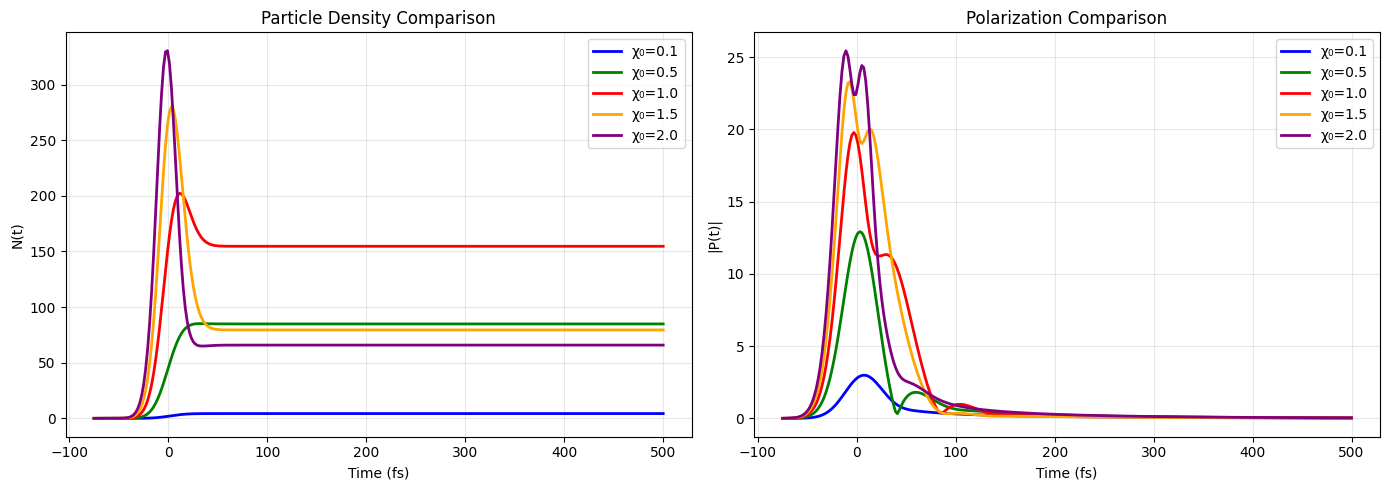

In [5]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['blue', 'green', 'red', 'orange', 'purple']

# Compare particle density
for i, chi0 in enumerate(chi0_compare):
    axes[0].plot(results[chi0]['t'], results[chi0]['N_t'], 
                 linewidth=2, color=colors[i], label=f'χ₀={chi0}')
axes[0].set_xlabel('Time (fs)')
axes[0].set_ylabel('N(t)')
axes[0].set_title('Particle Density Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compare polarization
for i, chi0 in enumerate(chi0_compare):
    axes[1].plot(results[chi0]['t'], results[chi0]['P_t'], 
                 linewidth=2, color=colors[i], label=f'χ₀={chi0}')
axes[1].set_xlabel('Time (fs)')
axes[1].set_ylabel('|P(t)|')
axes[1].set_title('Polarization Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment 3: 3D Visualization - Occupation Numbers

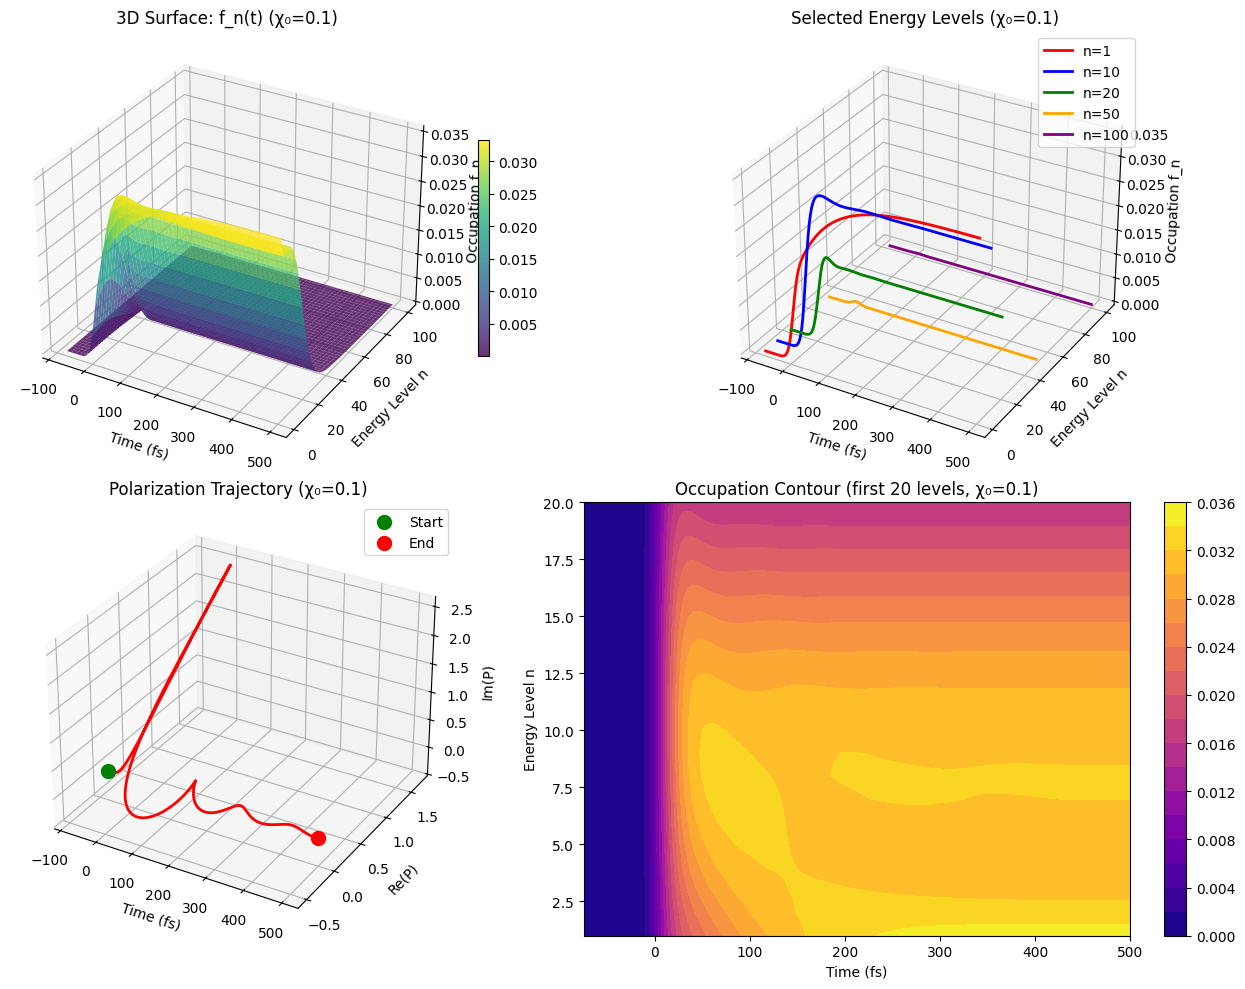

In [6]:
# Choose which chi0 to visualize in 3D
chi0_3d = 0.1

f_n_3d = results[chi0_3d]['f_n']
t_3d = results[chi0_3d]['t']

fig = plt.figure(figsize=(14, 10))

# 3D Surface plot
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
T, N_levels = np.meshgrid(t_3d, np.arange(1, N+1))
Z = f_n_3d.T
surf = ax1.plot_surface(T, N_levels, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Time (fs)')
ax1.set_ylabel('Energy Level n')
ax1.set_zlabel('Occupation f_n')
ax1.set_title(f'3D Surface: f_n(t) (χ₀={chi0_3d})')
plt.colorbar(surf, ax=ax1, shrink=0.5)

# 3D Wireframe for selected levels
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
selected = [0, 9, 19, 49, 99]
colors_3d = ['red', 'blue', 'green', 'orange', 'purple']
for i, level in enumerate(selected):
    if level < N:
        ax2.plot(t_3d, [level+1]*len(t_3d), f_n_3d[:, level],
                color=colors_3d[i], linewidth=2, label=f'n={level+1}')
ax2.set_xlabel('Time (fs)')
ax2.set_ylabel('Energy Level n')
ax2.set_zlabel('Occupation f_n')
ax2.set_title(f'Selected Energy Levels (χ₀={chi0_3d})')
ax2.legend()

# Polarization trajectory
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
p_n_3d = results[chi0_3d]['p_n']
P_real = np.real(np.sum(p_n_3d, axis=1))
P_imag = np.imag(np.sum(p_n_3d, axis=1))
ax3.plot(t_3d, P_real, P_imag, color='red', linewidth=2)
ax3.scatter(t_3d[0], P_real[0], P_imag[0], color='green', s=100, label='Start')
ax3.scatter(t_3d[-1], P_real[-1], P_imag[-1], color='red', s=100, label='End')
ax3.set_xlabel('Time (fs)')
ax3.set_ylabel('Re(P)')
ax3.set_zlabel('Im(P)')
ax3.set_title(f'Polarization Trajectory (χ₀={chi0_3d})')
ax3.legend()

# Contour plot
ax4 = fig.add_subplot(2, 2, 4)
n_contour = min(20, N)
contour = ax4.contourf(t_3d, np.arange(1, n_contour+1), 
                        f_n_3d[:, :n_contour].T, levels=20, cmap='plasma')
ax4.set_xlabel('Time (fs)')
ax4.set_ylabel('Energy Level n')
ax4.set_title(f'Occupation Contour (first {n_contour} levels, χ₀={chi0_3d})')
plt.colorbar(contour, ax=ax4)

plt.tight_layout()
plt.show()

## Experiment 4: Parameter Sensitivity

Explore how different parameters affect the system dynamics.

Testing different T2 values...
  ✓ T2 = 50 fs
  ✓ T2 = 100 fs
  ✓ T2 = 200 fs
  ✓ T2 = 400 fs


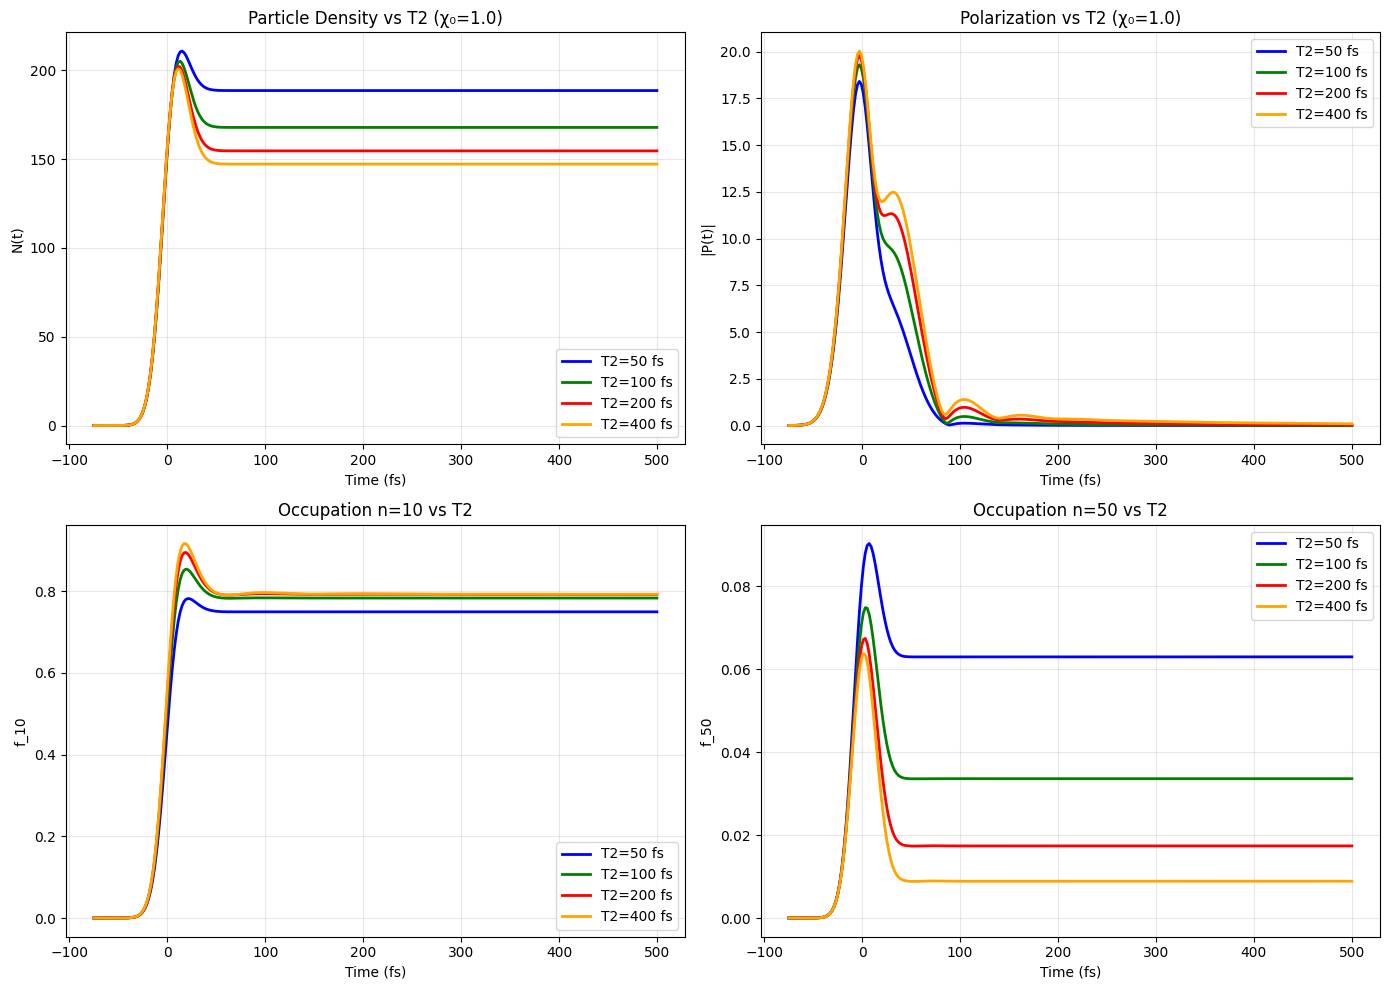

Analysis complete!


In [7]:
# Test different dephasing times T2
T2_values = [50, 100, 200, 400]
chi0_test = 1.0

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['blue', 'green', 'red', 'orange']

print("Testing different T2 values...")
for i, T2_test in enumerate(T2_values):
    y0 = np.zeros(3*N)
    args = (chi0_test, delta_t, Delta_0, T2_test, E_R, Delta_epsilon, g_matrix)
    t_test, y_test = rk4(bloch_equations, t_0, t_max, N_steps, y0, args)
    
    f_n_test = y_test[:, :N]
    p_n_test = y_test[:, N:2*N] + 1j * y_test[:, 2*N:3*N]
    
    N_t_test = C0 * np.sum(np.sqrt(np.arange(1, N+1)) * f_n_test, axis=1)
    P_t_test = np.abs(np.sum(p_n_test, axis=1))
    
    
    # Plot particle density
    axes[0, 0].plot(t_test, N_t_test, linewidth=2, color=colors[i], label=f'T2={T2_test} fs')
    
    # Plot polarization
    axes[0, 1].plot(t_test, P_t_test, linewidth=2, color=colors[i], label=f'T2={T2_test} fs')
    
    # Plot occupation of n=10
    axes[1, 0].plot(t_test, f_n_test[:, 9], linewidth=2, color=colors[i], label=f'T2={T2_test} fs')
    
    # Plot occupation of n=50
    axes[1, 1].plot(t_test, f_n_test[:, 49], linewidth=2, color=colors[i], label=f'T2={T2_test} fs')
    
    print(f"  ✓ T2 = {T2_test} fs")

axes[0, 0].set_xlabel('Time (fs)')
axes[0, 0].set_ylabel('N(t)')
axes[0, 0].set_title(f'Particle Density vs T2 (χ₀={chi0_test})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_xlabel('Time (fs)')
axes[0, 1].set_ylabel('|P(t)|')
axes[0, 1].set_title(f'Polarization vs T2 (χ₀={chi0_test})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_xlabel('Time (fs)')
axes[1, 0].set_ylabel('f_10')
axes[1, 0].set_title('Occupation n=10 vs T2')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_xlabel('Time (fs)')
axes[1, 1].set_ylabel('f_50')
axes[1, 1].set_title('Occupation n=50 vs T2')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Analysis complete!")

## Experiment 5: Energy Spectrum Analysis

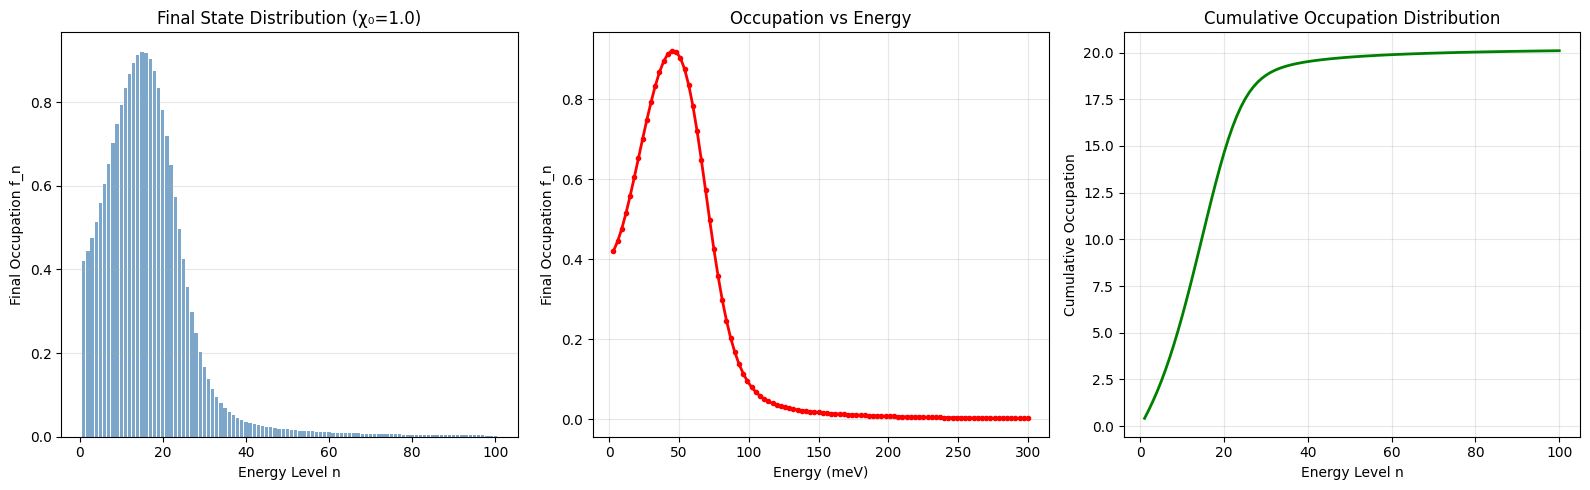

Total final occupation: 20.097012
Mean energy level: 16.45
Max occupation at level: 15


In [8]:
# Analyze final state occupation numbers
chi0_spectrum = 1.0

f_n_final = results[chi0_spectrum]['f_n'][-1, :]
energy_levels = np.arange(1, N+1) * Delta_epsilon

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Final occupation spectrum
axes[0].bar(np.arange(1, N+1), f_n_final, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Energy Level n')
axes[0].set_ylabel('Final Occupation f_n')
axes[0].set_title(f'Final State Distribution (χ₀={chi0_spectrum})')
axes[0].grid(True, alpha=0.3, axis='y')

# Occupation vs energy
axes[1].plot(energy_levels, f_n_final, 'o-', linewidth=2, markersize=3, color='red')
axes[1].set_xlabel('Energy (meV)')
axes[1].set_ylabel('Final Occupation f_n')
axes[1].set_title('Occupation vs Energy')
axes[1].grid(True, alpha=0.3)

# Cumulative occupation
cumulative = np.cumsum(f_n_final)
axes[2].plot(np.arange(1, N+1), cumulative, linewidth=2, color='green')
axes[2].set_xlabel('Energy Level n')
axes[2].set_ylabel('Cumulative Occupation')
axes[2].set_title('Cumulative Occupation Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total final occupation: {np.sum(f_n_final):.6f}")
print(f"Mean energy level: {np.average(np.arange(1, N+1), weights=f_n_final+1e-10):.2f}")
print(f"Max occupation at level: {np.argmax(f_n_final)+1}")

## Experiment 6: Custom Parameters

Create your own experiment by modifying the parameters below!

Running custom simulation...
  χ₀ = 1.5
  δt = 30.0 fs
  Δ₀ = 20.0 meV
  T₂ = 150.0 fs
✓ Custom simulation complete!


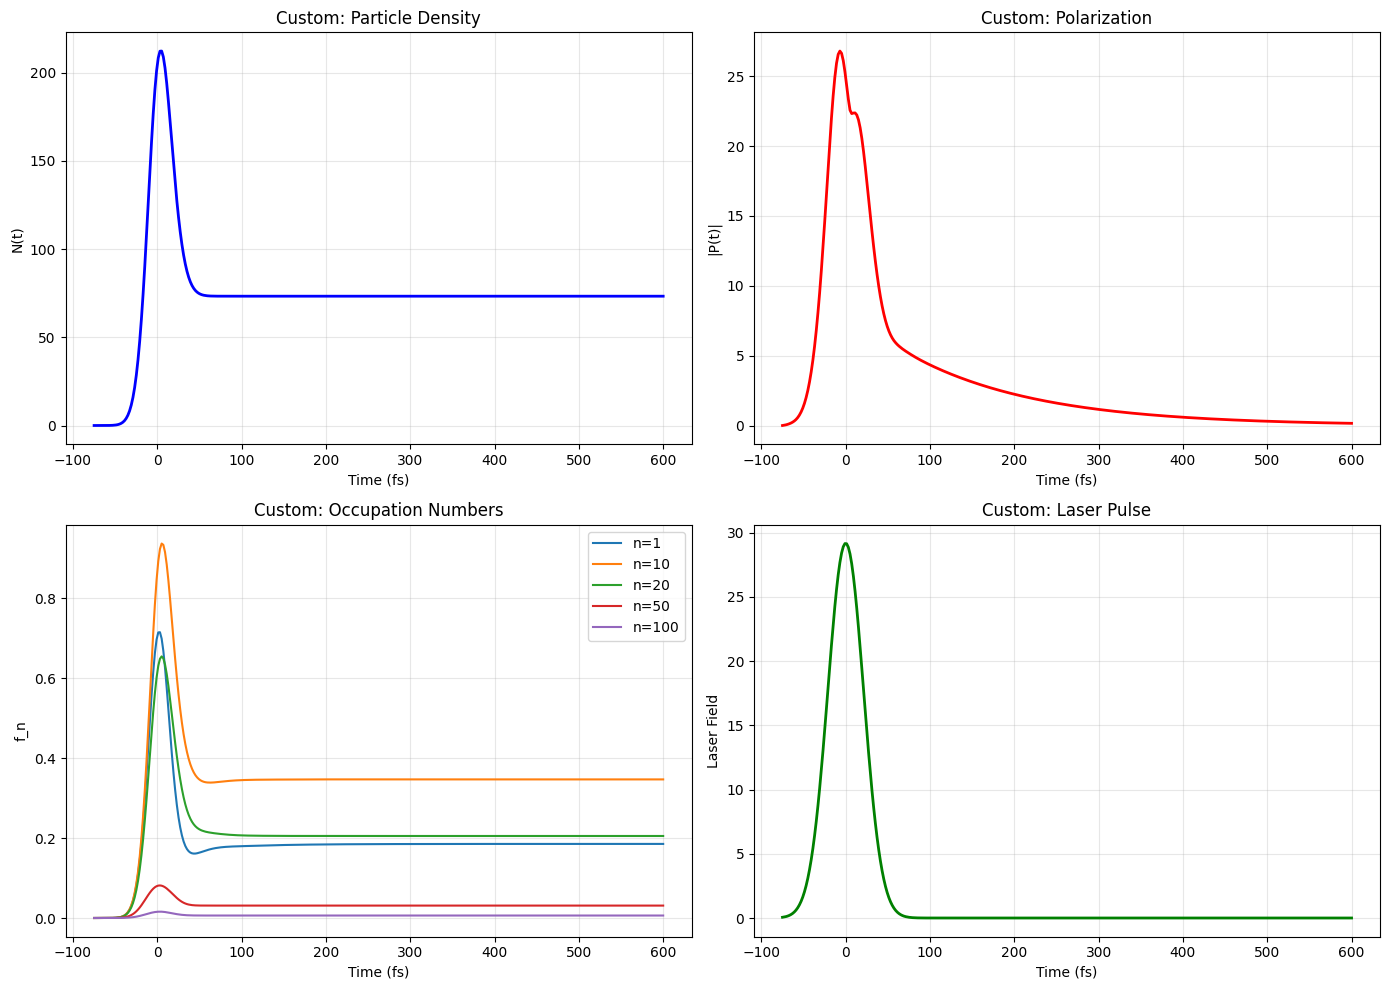

In [9]:
# Custom parameters - modify these!
custom_chi0 = 1.5          # Laser intensity
custom_delta_t = 30.0      # Laser pulse width (fs)
custom_Delta_0 = 20.0      # Detuning (meV)
custom_T2 = 150.0          # Dephasing time (fs)
custom_t_max = 600.0       # Simulation time (fs)

print("Running custom simulation...")
print(f"  χ₀ = {custom_chi0}")
print(f"  δt = {custom_delta_t} fs")
print(f"  Δ₀ = {custom_Delta_0} meV")
print(f"  T₂ = {custom_T2} fs")

y0_custom = np.zeros(3*N)
N_steps_custom = int((custom_t_max - t_0) / dt)
args_custom = (custom_chi0, custom_delta_t, custom_Delta_0, custom_T2, E_R, Delta_epsilon, g_matrix)

t_custom, y_custom = rk4(bloch_equations, t_0, custom_t_max, N_steps_custom, y0_custom, args_custom)

f_n_custom = y_custom[:, :N]
p_n_custom = y_custom[:, N:2*N] + 1j * y_custom[:, 2*N:3*N]

N_t_custom = C0 * np.sum(np.sqrt(np.arange(1, N+1)) * f_n_custom, axis=1)
P_t_custom = np.sum(np.abs(p_n_custom), axis=1)

print("✓ Custom simulation complete!")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(t_custom, N_t_custom, linewidth=2, color='blue')
axes[0, 0].set_xlabel('Time (fs)')
axes[0, 0].set_ylabel('N(t)')
axes[0, 0].set_title('Custom: Particle Density')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(t_custom, P_t_custom, linewidth=2, color='red')
axes[0, 1].set_xlabel('Time (fs)')
axes[0, 1].set_ylabel('|P(t)|')
axes[0, 1].set_title('Custom: Polarization')
axes[0, 1].grid(True, alpha=0.3)

for level in [0, 9, 19, 49, 99]:
    if level < N:
        axes[1, 0].plot(t_custom, f_n_custom[:, level], linewidth=1.5, label=f'n={level+1}')
axes[1, 0].set_xlabel('Time (fs)')
axes[1, 0].set_ylabel('f_n')
axes[1, 0].set_title('Custom: Occupation Numbers')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

laser_custom = [laser_pulse(ti, custom_chi0, custom_delta_t) for ti in t_custom]
axes[1, 1].plot(t_custom, laser_custom, linewidth=2, color='green')
axes[1, 1].set_xlabel('Time (fs)')
axes[1, 1].set_ylabel('Laser Field')
axes[1, 1].set_title('Custom: Laser Pulse')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Export

Save your experimental results for further analysis.

In [10]:
# Export custom results to CSV
export_data = np.column_stack((t_custom, N_t_custom, P_t_custom, f_n_custom[:, :10]))
header = 't,N_t,P_t,' + ','.join([f'f_{i+1}' for i in range(10)])

filename = f'data/custom_experiment_chi0_{custom_chi0:.1f}.csv'
np.savetxt(filename, export_data, delimiter=',', header=header, comments='')

print(f"✓ Data exported to: {filename}")
print(f"\nExperiment Summary:")
print(f"  Max N(t): {np.max(N_t_custom):.4f}")
print(f"  Max |P(t)|: {np.max(P_t_custom):.4f}")
print(f"  Final total occupation: {np.sum(f_n_custom[-1, :]):.6f}")
print(f"  Time range: {t_custom[0]:.1f} to {t_custom[-1]:.1f} fs")

✓ Data exported to: data/custom_experiment_chi0_1.5.csv

Experiment Summary:
  Max N(t): 212.3435
  Max |P(t)|: 26.8024
  Final total occupation: 8.704103
  Time range: -75.0 to 600.0 fs
